# NLP. Task №2. Text Classification

**by Maria Ismailova**

The task: 
Classify news to one of 5 categories based on text

1. Choose and argue your measure of a test's accuracy
2. Build data processing and classification pipeline
3. Tune  your model

While completing this task I used:
- NLP lectures
- several Internet-based articles
- some examples of coding

# Data inspection

In [457]:
# loading the libraries

import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [458]:
# loading the bbc dataset using os library

data_folder = "/Users/mariaismailova/Documents/Study/NL&IP/bbc-2"
folders = ["business","entertainment","politics","sport","tech"]

os.chdir(data_folder)

x = []
y = []

for i in folders:
    files = os.listdir(i)
    for text_file in files:
        file_path = i + "/" + text_file
        with open(file_path, encoding = 'utf-8', errors = 'ignore') as f:
            data = f.readlines()
        data = ' '.join(data)
        x.append(data)
        y.append(i)
 
data = {'news': x, 'category': y}       
df_bbc = pd.DataFrame(data)

# saving the dataset

df_bbc.to_csv('../dataset.csv', index = False)

In [459]:
# inspecting the data

df_bbc.head(10)

,news,category
0,UK economy facing 'major risks'\n \n The UK ma...,business
1,Aids and climate top Davos agenda\n \n Climate...,business
2,Asian quake hits European shares\n \n Shares i...,business
3,India power shares jump on debut\n \n Shares i...,business
4,Lacroix label bought by US firm\n \n Luxury go...,business
5,Insurance bosses plead guilty\n \n Another thr...,business
6,Turkey-Iran mobile deal 'at risk'\n \n Turkey'...,business
7,Parmalat to return to stockmarket\n \n Parmala...,business
8,WorldCom director admits lying\n \n The former...,business
9,Ebbers denies WorldCom fraud\n \n Former World...,business


In the beginning of our dataset we see business news.

In [460]:
# inspecting the data

df_bbc.tail(10)

,news,category
2215,"Argonaut founder rebuilds empire\n \n Jez San,...",tech
2216,Blind student 'hears in colour'\n \n A blind s...,tech
2217,Sony PSP tipped as a 'must-have'\n \n Sony's P...,tech
2218,Software watching while you work\n \n Software...,tech
2219,Norway upholds 'Napster' ruling\n \n A Norwegi...,tech
2220,Warning over Windows Word files\n \n Writing a...,tech
2221,Fast lifts rise into record books\n \n Two hig...,tech
2222,Nintendo adds media playing to DS\n \n Nintend...,tech
2223,Fast moving phone viruses appear\n \n Security...,tech
2224,Hacker threat to Apple's iTunes\n \n Users of ...,tech


In the end of our dataset we see tech news.

In [461]:
# inspecting the data

df_bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
news        2225 non-null object
category    2225 non-null object
dtypes: object(2)
memory usage: 34.8+ KB


In [462]:
# inspecting the data

df_bbc.describe()

,news,category
count,2225,2225
unique,2127,5
top,'Debate needed' on donations cap\n \n A cap on...,sport
freq,2,511


Our dataset consists of 2225 news of 5 unique categories, 98 news are not unique, sport is the most frequent category.

In [463]:
# inspecting the data

df_bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

Categories are not distributed equally, but there is no sample imbalance problem, the most frequent group is sport, the less - entertainment.

In [464]:
# relative frequency

df_bbc['category'].value_counts(normalize = True)

sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: category, dtype: float64

In [465]:
# adding a column encoding the category as an integer

df_bbc['category_id'] = df_bbc['category'].factorize()[0]

In [466]:
# checking data with new column

df_bbc.head(5)

,news,category,category_id
0,UK economy facing 'major risks'\n \n The UK ma...,business,0
1,Aids and climate top Davos agenda\n \n Climate...,business,0
2,Asian quake hits European shares\n \n Shares i...,business,0
3,India power shares jump on debut\n \n Shares i...,business,0
4,Lacroix label bought by US firm\n \n Luxury go...,business,0


In [467]:
# checking data with new column

df_bbc.tail(5)

,news,category,category_id
2220,Warning over Windows Word files\n \n Writing a...,tech,4
2221,Fast lifts rise into record books\n \n Two hig...,tech,4
2222,Nintendo adds media playing to DS\n \n Nintend...,tech,4
2223,Fast moving phone viruses appear\n \n Security...,tech,4
2224,Hacker threat to Apple's iTunes\n \n Users of ...,tech,4


'Distribution of categories of news'

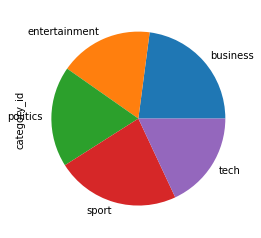

In [468]:
# graph of distribution of categories

df_bbc.groupby('category').category_id.count().plot.pie()
('Distribution of categories of news')

# Text representation

For each term in our dataset, we will calculate a measure called Term frequency, Inverse document frequncy.

Converting news into TFIDF feature values:
- sublinear_tf is set to True: logarithmic form for frequency
- min_df is set to 10: a word must be present at least in 10 documents in order to be kept
- norm is set to l2: all our feature vectors have euclidian norm of 1
- ngram_range is set to (1, 2): consider both unigrams and bigrams
- stop_words is set to english: remove all common pronouns

In [469]:
# converting news into TFIDF feature values:

tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 10, norm = 'l2', ngram_range = (1, 2), stop_words = 'english')
features = tfidf.fit_transform(df_bbc.news).toarray()
labels = df_bbc.category_id
features.shape

(2225, 6842)

Now, each of 2225 news  is represented by 6842 features, representing the tf-idf score for different unigrams and bigrams.

# Multi-class classifiers

### Splitting the data

In [470]:
# splitting the data on train and test samples

X_train, x_test, Y_train, y_test = train_test_split(features, labels, test_size = 0.2)

The above script divides data into 20% test set and 80% training set.

In [471]:
# checking samples' length

len(X_train), len(x_test)

(1780, 445)

### Choosing measure of accuracy

F1-score is a good candidate for a formal classifier quality assessment metric. It reduces to one number two other fundamental metrics: precision and recall. As we have to evaluate multi-class quality, we should use an average measure (summing measures for every class and then deviding by the number of classes). Since there is no sample imbalance problem, we should use macro average f1-score.

### Naive Bayes Classifier

In [472]:
# building multinomial naive bayes classifier

NB_clf = MultinomialNB()
NB_clf.fit(X_train, Y_train)
NB_clf_pred = NB_clf.predict(x_test)

In [473]:
# confusion matrix for naive bayes

print(confusion_matrix(y_test, NB_clf_pred))

[[93  0  1  0  1]
 [ 2 76  1  0  4]
 [ 2  0 82  0  0]
 [ 1  0  0 94  0]
 [ 0  1  0  0 87]]


In [474]:
# accuracy score for naive bayes

print(accuracy_score(y_test, NB_clf_pred))

0.9707865168539326


In [475]:
# classification report for naive bayes

print(classification_report(y_test, NB_clf_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        95
           1       0.99      0.92      0.95        83
           2       0.98      0.98      0.98        84
           3       1.00      0.99      0.99        95
           4       0.95      0.99      0.97        88

   micro avg       0.97      0.97      0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



**Macro avg f1-score**: 0,97

### Log-regression classifier

In [476]:
# building logistic regression classifier

LR_clf = LogisticRegression()
LR_clf.fit(X_train, Y_train)
LR_clf_pred = LR_clf.predict(x_test)

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [477]:
# confusion matrix for logistic regression

print(confusion_matrix(y_test, LR_clf_pred))

[[93  0  1  0  1]
 [ 2 80  1  0  0]
 [ 2  0 82  0  0]
 [ 1  0  0 94  0]
 [ 0  1  0  0 87]]


In [478]:
# accuracy score for logistic regression

print(accuracy_score(y_test, LR_clf_pred))

0.9797752808988764


In [479]:
# classification report for logistic regression

print(classification_report(y_test, LR_clf_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        95
           1       0.99      0.96      0.98        83
           2       0.98      0.98      0.98        84
           3       1.00      0.99      0.99        95
           4       0.99      0.99      0.99        88

   micro avg       0.98      0.98      0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



**Macro avg f1-score**: 0,98

### Random forest classifier

In [480]:
# building random forest classifier

RF_clf = RandomForestClassifier(n_estimators = 1000, random_state=0)
RF_clf.fit(X_train, Y_train)
RF_clf_pred = RF_clf.predict(x_test)

In [481]:
# confusion matrix for random forest

print(confusion_matrix(y_test,RF_clf_pred))

[[92  0  1  0  2]
 [ 2 79  1  0  1]
 [ 2  0 82  0  0]
 [ 1  0  0 94  0]
 [ 1  2  0  1 84]]


In [482]:
# accuracy score for random forest

print(accuracy_score(y_test, RF_clf_pred))

0.9685393258426966


In [483]:
# classification report for random forest

print(classification_report(y_test,RF_clf_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       0.98      0.95      0.96        83
           2       0.98      0.98      0.98        84
           3       0.99      0.99      0.99        95
           4       0.97      0.95      0.96        88

   micro avg       0.97      0.97      0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



**Macro avg f1-score**: 0,97

### Linear SVM classifier

In [484]:
# building support vector machine classifier

SVC_clf = LinearSVC()
SVC_clf.fit(X_train, Y_train)
SVC_clf_pred = SVC_clf.predict(x_test)

In [485]:
# confusion matrix for support vector machine
print(confusion_matrix(y_test,SVC_clf_pred))

[[93  0  1  0  1]
 [ 2 80  1  0  0]
 [ 2  0 81  0  1]
 [ 1  0  0 94  0]
 [ 0  1  0  0 87]]


In [486]:
# accuracy score for support vector machine
print(accuracy_score(y_test, SVC_clf_pred))

0.9775280898876404


In [487]:
# classification report for support vector machine
print(classification_report(y_test,SVC_clf_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        95
           1       0.99      0.96      0.98        83
           2       0.98      0.96      0.97        84
           3       1.00      0.99      0.99        95
           4       0.98      0.99      0.98        88

   micro avg       0.98      0.98      0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



**Macro avg f1-score**: 0,98

Since the highest macro average f1-score is for log-regression and support vector machine classifiers, we will futher work with them and try to tune them.

### Tunning the model

In [492]:
tuned_parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
LR_clf_tuned = GridSearchCV(LogisticRegression(solver = 'liblinear'), tuned_parameters, cv = 20, scoring = "f1_macro")
LR_clf_tuned.fit(X_train, Y_train)

print("Best parameters:", LR_clf_tuned.best_params_)
print("Best score:", LR_clf_tuned.best_score_)

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  

Best parameters: {'C': 50}
Best score: 0.9834186033573485


In [493]:
tuned_parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
SVC_clf_tuned = GridSearchCV(LinearSVC(), tuned_parameters, cv = 100, scoring = "f1_macro")
SVC_clf_tuned.fit(X_train, Y_train)

print("Best parameters:", SVC_clf_tuned.best_params_)
print("Best score:", SVC_clf_tuned.best_score_)

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear f

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear f

/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaismailova/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear f

Best parameters: {'C': 50}
Best score: 0.9837530359777551


**Logistic regression classifier**: with C = 50 the best score is: 0,9834

**Support vector machine classifier**: with C = 50 the best score is: 0,9838